In [29]:
# Read Data
import numpy as np
import pandas as pd

In [30]:
%run ../src/campus_src.py

In [31]:
df = pd.read_csv("../data/processed/campus_processed.csv")
df = df.set_index("DateTime")

## Create Dataset

In [32]:
# 假設 df_encoded 是你的 DataFrame，且已經按時間順序排序
#n_steps = 8  # 例如，使用t以及前面5步作為特徵
#論文設定成3
n_steps = 3
X, y = create_dataset(df.to_numpy(), n_steps)

print(y)
print(X.shape)
print(y.shape)

[222.326142 220.546435 205.955438 ...  73.581269 156.333926 222.44631 ]
(4316, 3, 35)
(4316,)


## Split

In [33]:
X_train, X_validation, X_test, y_train, y_validation, y_test = split_dataset(X, y, train_ratio=0.75, validation_ratio=0.15)

## Attack

In [34]:
def attack_all_add_pct(X, step_idx=7, feat_idx=1, pct=0.05):
    """
    对 X 中所有样本，在指定的 step_idx 和 feat_idx 位置，
    将原值增加 pct * 原值（即乘以 1+pct）。

    参数：
        X (np.ndarray): 待“攻击”的三维数组，shape=(n_samples, n_steps, n_features)
        step_idx (int): 时间步的索引，比如第8步就传 7
        feat_idx (int): 特征的索引，比如第2个特征就传 1
        pct (float): 增加比例，默认 0.05（5%）

    返回：
        np.ndarray: 攻击后的数组副本
    """
    X_attacked = X.copy()
    X_attacked[:, step_idx, feat_idx] *= (1 + pct)
    return X_attacked

#X_test_attacked = attack_all_add_pct(X_test, step_idx=7, feat_idx=1, pct=0.2)
#X_test_attacked = attack_all_add_pct(X_test_attacked, step_idx=7, feat_idx=2, pct=0.2)

#X_test = X_test_attacked.copy()

## Scaler

In [16]:
X_train, X_validation, X_test = scaling(X_train, X_validation, X_test, 3)

## =====================

## Model

In [35]:
"""
for i in range(len(X_train)): #每個X_train
  # 应用噪声
  X_train[i] = add_noise(X_train[i], noise_level=0.05)
"""

'\nfor i in range(len(X_train)): #每個X_train\n  # 应用噪声\n  X_train[i] = add_noise(X_train[i], noise_level=0.05)\n'

In [ ]:
import tcn
from tensorflow.keras.models import load_model

loaded_model = load_model(
    "../models/tf/capacity.keras",
    custom_objects={
        "TCN": tcn.TCN,
        #"ResidualBlock": tcn.ResidualBlock,
        "cap_loss": cap_loss  # 如果定义了类似的自定义损失，就把它也传进来
    }
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (386946223.py, line 7)

In [37]:
import numpy as np
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_validation = np.array(X_validation, dtype=np.float32)
y_validation = np.array(y_validation, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[early_stopping]  # 加入早期停止回調函數
)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - MAE: 79.1994 - loss: 119.3109 - val_MAE: 22.9155 - val_loss: 38.6077
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - MAE: 32.6993 - loss: 50.0067 - val_MAE: 30.4017 - val_loss: 33.6839
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - MAE: 35.9790 - loss: 45.9527 - val_MAE: 27.7954 - val_loss: 33.2970
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - MAE: 30.8649 - loss: 42.2973 - val_MAE: 27.5963 - val_loss: 31.6693
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - MAE: 28.5947 - loss: 41.2914 - val_MAE: 30.1347 - val_loss: 34.6981
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - MAE: 29.5933 - loss: 39.9987 - val_MAE: 23.7421 - val_loss: 30.3442
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - MAE: 26.2122 - loss: 37.6934 - val_MAE: 19.5215 - val_loss: 29.3229
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - MAE: 25.4564 - loss: 36.5347 - val_MAE: 29.0847 - val_loss: 31.1082
Epoch 9/100
26/26 ━━━━━

In [ ]:
traffic_model = build_model_TCN(n_steps, X_train.shape[2])
history = traffic_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[early_stopping]  # 加入早期停止回調函數
)

# —— 使用示例 —— #
epsilon = 0.2
X_test_adv = None
# 时间维度上，论文中的 FGSM 只针对 当前时刻 𝑡 的快照进行扰动，不会“连带”把 𝑡 − 1 , 𝑡 − 2 , … t−1,t−2,… 一并改动；
X_test_adv = fgsm_inject_one_pos(traffic_model, X_test, y_test, epsilon)#, step_idx=n_steps-1, feat_idx=1)
X_test_adv = fgsm_inject_one_pos(traffic_model, X_test_adv, y_test, epsilon)#, step_idx=n_steps-1, feat_idx=2)
preds_clean = traffic_model.predict(X_test)
preds_adv   = traffic_model.predict(X_test_adv)    # 一定要传 X_test_adv
print("max abs diff:", np.max(np.abs(preds_adv - preds_clean)))

grad_sign 在 (step,feat)= None None 上的值： [0. 1.]
grad_sign 在 (step,feat)= None None 上的值： [0. 1.]
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
max abs diff: 3.2011642


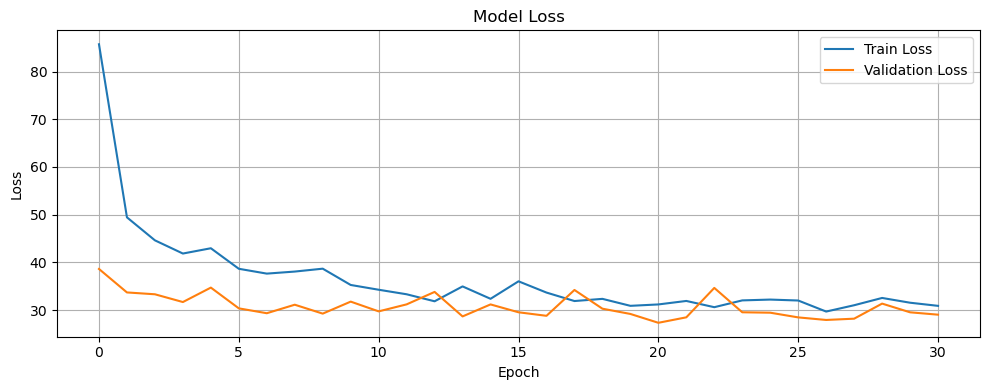

In [40]:
plot_loss(history)

Testing Length: 432
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


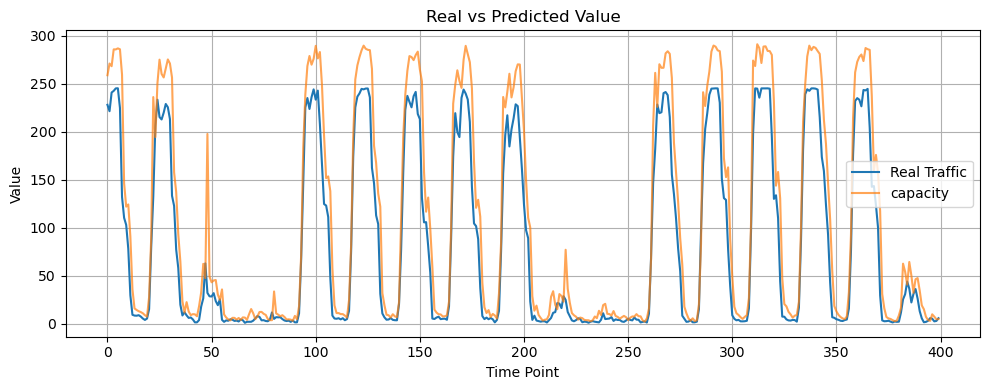

In [41]:
plot_predictions(model, X_test_adv, y_test, start=0, end=400, label="capacity")

Testing Length: 432
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


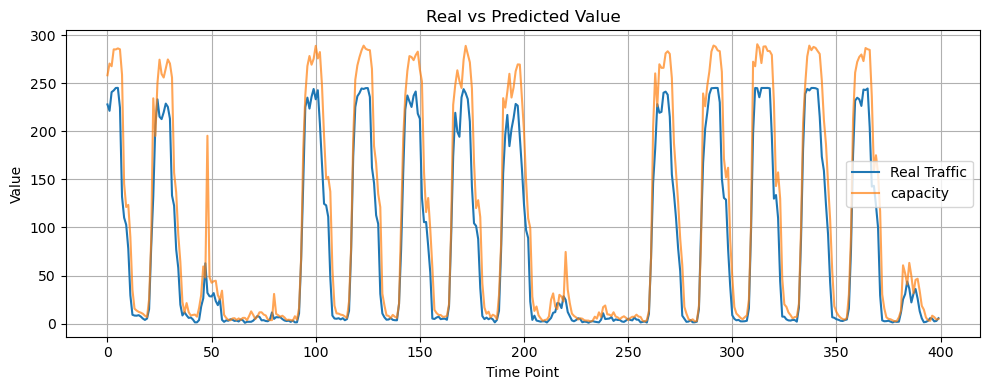

In [42]:
plot_predictions(model, X_test, y_test, start=0, end=400, label="capacity")

In [28]:
violation_rate, num_violations, total = compute_violation_rate(model, X_test, y_test)
print(f"違約率: {violation_rate*100:.2f}% ({num_violations}/{total})")

violation_rate, num_violations, total = compute_violation_rate(model, X_test_adv, y_test)
print(f"違約率: {violation_rate*100:.2f}% ({num_violations}/{total})")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
違約率: 16.67% (72/432)
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
違約率: 16.67% (72/432)


In [25]:
predicted = model.predict(X_test).reshape(-1, 1)
result_normal = evaluate_regression(y_test, predicted)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Absolute Error: 8.474785804748535
Mean Squared Error: 150.19699096679688
Root Mean Squared Error: 12.255488197815575
R^2 Score: 0.9827482104301453
Mean Absolute Percentage Error: 0.7657817006111145


In [26]:
predicted = model.predict(X_test_adv).reshape(-1, 1)
result_attacked = evaluate_regression(y_test, predicted)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Absolute Error: 32.162349700927734
Mean Squared Error: 1383.37548828125
Root Mean Squared Error: 37.19375603890053
R^2 Score: 0.8411042094230652
Mean Absolute Percentage Error: 4.35919713973999


In [330]:
# Create a DataFrame to compare the values
df_compare = pd.DataFrame({
    'Metric': list(result_normal.keys()),
    'Normal': list(result_normal.values()),
    'Attacked': list(result_attacked.values())
})

# Calculate absolute and percentage differences
df_compare['Absolute Difference'] = df_compare['Attacked'] - df_compare['Normal']
df_compare['% Difference'] = ((df_compare['Absolute Difference'] / df_compare['Normal']) * 100)
df_compare

,Metric,Normal,Attacked,Absolute Difference,% Difference
0,MAE,6.848458,9.084687,2.236229,32.653036
1,MSE,110.009964,157.027420,47.017456,42.739270
2,RMSE,10.488563,12.531058,2.042495,19.473541
3,R2,0.987364,0.981964,-0.005400,-0.546959
4,MAPE,0.382416,0.767118,0.384701,100.597517


In [ ]:
import os
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

# 定義一個函式，強制從 _1 開始依序編號檔名
def get_unique_filename(filename):
    """
    不論檔案是否存在，皆從 _1 開始附加到檔名上，
    若有同樣編號的檔案存在，則依序累加編號，直到找到尚不存在的檔名。
    """
    base, ext = os.path.splitext(filename)
    i = 1
    unique_filename = f"{base}_{i}{ext}"
    while os.path.exists(unique_filename):
        i += 1
        unique_filename = f"{base}_{i}{ext}"
    return unique_filename

# ------------------------
# 對測試集進行預測及計算指標
# ------------------------

# 進行測試集預測並轉換成一維陣列
predicted_test = model.predict(X_test).reshape(-1, 1)

# 計算各項回歸評估指標
mse = mean_squared_error(y_test, predicted_test)
mae = mean_absolute_error(y_test, predicted_test)
rmse = sqrt(mse)
r2 = r2_score(y_test, predicted_test)
mape = mean_absolute_percentage_error(y_test, predicted_test)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')
print(f'MAPE: {mape}')

# 將測試集真值與預測結果合併成 DataFrame
test_results = pd.DataFrame({
    'True': y_test.flatten(),
    'Predicted': predicted_test.flatten()
})

# 取得唯一檔名並儲存測試集結果成 CSV 檔案
test_csv_filename = get_unique_filename('test_predictions.csv')
test_results.to_csv(test_csv_filename, index=False)
print(f"測試集結果儲存到檔案: {test_csv_filename}")

# ------------------------
# 對訓練集進行預測並儲存結果
# ------------------------

# 預測訓練集資料
predicted_train = model.predict(X_train).reshape(-1, 1)

# 將訓練集真值與預測結果合併成 DataFrame
train_results = pd.DataFrame({
    'True': y_train.flatten(),
    'Predicted': predicted_train.flatten()
})

# 取得唯一檔名並儲存訓練集結果成 CSV 檔案
train_csv_filename = get_unique_filename('train_predictions.csv')
train_results.to_csv(train_csv_filename, index=False)
print(f"訓練集結果儲存到檔案: {train_csv_filename}")

# 結果分析

## 每小時誤差

In [ ]:
for index, row in df_extraction.iterrows():
  for i in range(len(y_test)):
    if (row["value_avg"]/1000000) == y_test[i]:
      df_extraction.loc[index, "predicted"] = predicted[i][0]

In [ ]:
df_extraction_hour = df_extraction.dropna()

In [ ]:
df_extraction_hour["value_avg"] = df_extraction_hour["value_avg"] / 1000000

In [ ]:
df_extraction_hour

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = df_extraction_hour.copy()

hours = data.groupby(data["hour"])

mae = hours.apply(lambda x: np.mean(np.abs(x['value_avg'] - x['predicted'])))
rmse = hours.apply(lambda x: np.sqrt(np.mean((x['value_avg'] - x['predicted'])**2)))
mape = hours.apply(lambda x: np.mean(np.abs((x['value_avg'] - x['predicted']) / x['value_avg'])) * 100)

print('MAE for each hour:')
print(mae)
print('\nRMSE for each hour:')
print(rmse)
print('\nMAPE for each hour:')
print(mape)

hours = range(24)
plt.figure(figsize=(12, 6))
plt.plot(hours, mae, label='MAE')
plt.plot(hours, rmse, label='RMSE')
plt.plot(hours, mape, label='MAPE')
plt.xlabel('Hour')
plt.ylabel('Error')
plt.title('MAE, RMSE and MAPE for each hour')
plt.xticks(hours)
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = df_extraction_hour.copy()

hours = data.groupby(data["weekday"])

mae = hours.apply(lambda x: np.mean(np.abs(x['value_avg'] - x['predicted'])))
rmse = hours.apply(lambda x: np.sqrt(np.mean((x['value_avg'] - x['predicted'])**2)))
mape = hours.apply(lambda x: np.mean(np.abs((x['value_avg'] - x['predicted']) / x['value_avg'])) * 100)

print('MAE for each hour:')
print(mae)
print('\nRMSE for each hour:')
print(rmse)
print('\nMAPE for each hour:')
print(mape)

hours = range(7)
plt.figure(figsize=(12, 6))
plt.plot(hours, mae, label='MAE')
plt.plot(hours, rmse, label='RMSE')
plt.plot(hours, mape, label='MAPE')
plt.xlabel('Hour')
plt.ylabel('Error')
plt.title('MAE, RMSE and MAPE for each weekday')
plt.xticks(hours)
plt.legend()
plt.show()